# Music Listening Frequency and Emotional Impact  
### Are emotional benefits driven by genre, or by listening more overall?

Music is commonly used for emotional regulation, yet it remains unclear whether the emotional benefits people report are tied to *specific genres* or simply to *greater overall exposure to music*.  

This notebook analyzes self-reported survey data on listening habits and emotional effects to examine:

1) How frequently respondents listen to different genres (listening “dose”)  
2) Whether listening frequency is associated with reporting that music **improves** emotional state  
3) Whether any genre-specific associations persist after accounting for overall listening time (hours/day)

**Interpretation boundary:** This is observational, self-report data. Results describe **associations**, not causation.


In [29]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
import statsmodels.api as sm

from google.colab import drive
drive.mount('/content/drive')

#Interactive visualization
try:
    import plotly.graph_objects as go
    _PLOTLY_AVAILABLE = True
except Exception:
    _PLOTLY_AVAILABLE = False

# Display settings
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1) Load + prepare data

We:
- Identify the 16 genre-frequency columns (`Frequency [Genre]`)
- Encode listening frequency (“dose”): Never=0, Rarely=1, Sometimes=2, Very frequently=3  
- Encode perceived emotional effect as both:
  - a 3-level score: Worsen=-1, No effect=0, Improve=+1 (for simple association checks)
  - a binary label: Improve vs not Improve (for adjusted probability modeling)


In [31]:
# Data path
DATA_PATH = "/content/drive/MyDrive/Mental Health & Music/mxmh_survey_results.csv"

# Guardrail: fail if dataset is missing
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        "Dataset not found.\n\n"
        "Please download 'mxmh_survey_results.csv' from:\n"
        "https://www.kaggle.com/datasets/catherinerasgaitis/mxmh-survey-results\n\n"
        "Then update DATA_PATH accordingly."
    )

# Load dataset
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH)
print("Shape:", df.shape)

# Identify genre frequency columns (e.g., "Frequency [Rock]")
genre_cols = sorted([
    c for c in df.columns
    if c.startswith("Frequency [") and c.endswith("]")
])
print("Number of genre columns:", len(genre_cols))
print("Genres:", [c.replace("Frequency [", "").replace("]", "") for c in genre_cols])

# Clean key string fields used throughout the analysis
# Stripping whitespace avoids subtle mismatches during mapping
for c in ["Music effects", "Hours per day"] + genre_cols:
    df[c] = df[c].astype("string").str.strip()

# Convert hours/day to numeric for modeling
df["Hours per day"] = pd.to_numeric(df["Hours per day"], errors="coerce")

# Encode categorical responses into numeric representations
# Dose encodes listening frequency as an ordinal variable (0–3)
dose_map = {
    "Never": 0,
    "Rarely": 1,
    "Sometimes": 2,
    "Very frequently": 3
}

# Effect score encodes perceived emotional impact
effect_map = {
    "Worsen": -1,
    "No effect": 0,
    "Improve": 1
}

df["effect_score"] = df["Music effects"].map(effect_map)

# Binary outcome for logistic models: 1 = Improve, 0 = otherwise
df["improve_bin"] = (df["Music effects"] == "Improve").astype("float")

# Create numeric dose columns for each genre
dose_cols = []
for c in genre_cols:
    dcol = c + " (dose)"
    df[dcol] = df[c].map(dose_map)
    dose_cols.append(dcol)

# Core analysis subset:
# Restrict to respondents with a valid Music effects response
core = df.dropna(subset=["Music effects"]).copy()
print("Rows with Music effects:", len(core))

# Preview cleaned data
core.head()

Loaded: /content/drive/MyDrive/Mental Health & Music/mxmh_survey_results.csv
Shape: (736, 33)
Number of genre columns: 16
Genres: ['Classical', 'Country', 'EDM', 'Folk', 'Gospel', 'Hip hop', 'Jazz', 'K pop', 'Latin', 'Lofi', 'Metal', 'Pop', 'R&B', 'Rap', 'Rock', 'Video game music']
Rows with Music effects: 728


,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Gospel],Frequency [Hip hop],Frequency [Jazz],Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions,effect_score,improve_bin,Frequency [Classical] (dose),Frequency [Country] (dose),Frequency [EDM] (dose),Frequency [Folk] (dose),Frequency [Gospel] (dose),Frequency [Hip hop] (dose),Frequency [Jazz] (dose),Frequency [K pop] (dose),Frequency [Latin] (dose),Frequency [Lofi] (dose),Frequency [Metal] (dose),Frequency [Pop] (dose),Frequency [R&B] (dose),Frequency [Rap] (dose),Frequency [Rock] (dose),Frequency [Video game music] (dose)
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,132.0,Never,Never,Very frequently,Never,Never,Rarely,Rarely,Very frequently,Never,Sometimes,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.,0.0,0.0,0,0,3,0,0,1,1,3,0,2,2,1,0,1,1,3
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,84.0,Sometimes,Never,Never,Rarely,Sometimes,Never,Very frequently,Sometimes,Very frequently,Sometimes,Never,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.,1.0,1.0,2,0,0,1,2,0,3,2,3,2,0,2,2,0,0,0
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,107.0,Never,Never,Rarely,Never,Rarely,Very frequently,Never,Very frequently,Sometimes,Sometimes,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.,1.0,1.0,0,0,1,0,1,3,0,3,2,2,0,2,3,3,0,1
5,8/27/2022 21:56:50,18.0,Spotify,5.0,Yes,Yes,Yes,Jazz,Yes,Yes,86.0,Rarely,Sometimes,Never,Never,Never,Sometimes,Very frequently,Very frequently,Rarely,Very frequently,Rarely,Very frequently,Very frequently,Very frequently,Very frequently,Never,8.0,8.0,7.0,7.0,Improve,I understand.,1.0,1.0,1,2,0,0,0,2,3,3,1,3,1,3,3,3,3,0
6,8/27/2022 22:00:29,18.0,YouTube Music,3.0,Yes,Yes,No,Video game music,Yes,Yes,66.0,Sometimes,Never,Rarely,Sometimes,Rarely,Rarely,Sometimes,Never,Rarely,Rarely,Rarely,Rarely,Rarely,Never,Never,Sometimes,4.0,8.0,6.0,0.0,Improve,I understand.,1.0,1.0,2,0,1,2,1,1,2,0,1,1,1,1,1,0,0,2


## 2) Outcome: do respondents feel music helps?

We begin with the overall distribution of self-reported music effects.  
This motivates why genre-specific analysis is relevant.


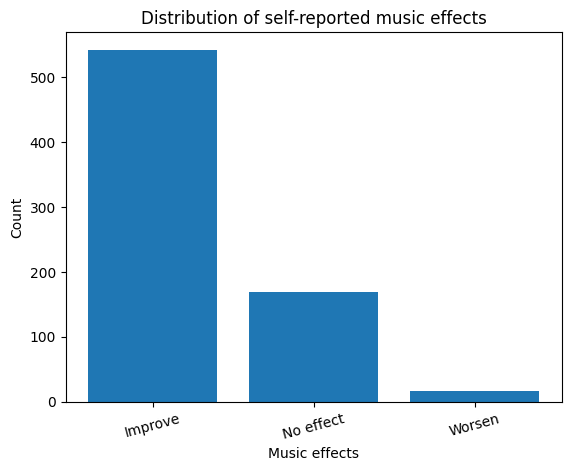

,count,share
Music effects,,
Improve,542,0.745
No effect,169,0.232
Worsen,17,0.023


In [23]:
# Distribution of self-reported emotional effects of music.
# This provides high-level context for the analysis by showing
# how respondents perceive music’s impact overall.

# Count responses in each effect category (Improve / No effect / Worsen)
counts = core["Music effects"].value_counts()

# Visualize the distribution as a simple bar chart
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Distribution of self-reported music effects")
plt.xlabel("Music effects")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.show()

# Tabulate counts and proportional shares for reference
summary = pd.DataFrame({
    "count": counts,
    "share": (counts / counts.sum()).round(3)
})

display(summary)

Most respondents report that music improves their emotional state, motivating further analysis of how listening patterns relate to perceived benefit.

## 3) Baseline listening behavior (context)

Before linking listening behavior to emotional outcomes, we summarize how frequently respondents listen to each genre.

This prevents over-interpreting later “effects” for genres that most people rarely listen to.


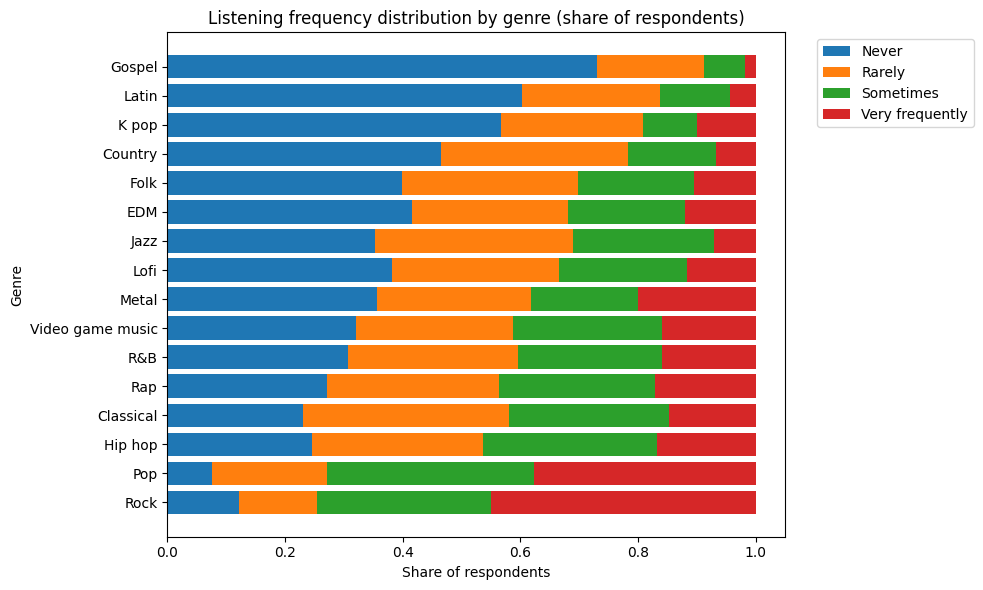

,genre,mean_dose,Never,Rarely,Sometimes,Very frequently
0,Rock,2.074176,0.122253,0.131868,0.295330,0.450549
1,Pop,2.030220,0.075549,0.195055,0.353022,0.376374
2,Hip hop,1.385989,0.245879,0.289835,0.296703,0.167582
3,Classical,1.336538,0.230769,0.350275,0.270604,0.148352
4,Rap,1.336538,0.271978,0.291209,0.265110,0.171703
5,R&B,1.255495,0.307692,0.288462,0.244505,0.159341
6,Video game music,1.251374,0.320055,0.267857,0.252747,0.159341
7,Metal,1.226648,0.355769,0.262363,0.181319,0.200549
8,Lofi,1.068681,0.381868,0.284341,0.217033,0.116758
9,Jazz,1.028846,0.353022,0.336538,0.239011,0.071429


In [22]:
# Distribution of listening frequency ("dose") levels per genre.
# This produces a stacked horizontal bar chart showing the share of respondents
# who report each frequency level (Never → Very frequently) for each genre.
# The goal is to understand baseline exposure differences across genres.

dist_rows = []

# Compute dose distributions for each genre
for gcol, dcol in zip(genre_cols, dose_cols):

    # Extract clean genre label
    gname = gcol.replace("Frequency [", "").replace("]", "")

    # Convert dose column to numeric and drop missing values
    tmp = pd.to_numeric(core[dcol], errors="coerce").dropna()

    # Calculate normalized shares for each dose level (0–3)
    # Reindex ensures all dose levels are present, even if some are absent
    shares = (
        tmp.value_counts(normalize=True)
           .reindex([0, 1, 2, 3])
           .fillna(0)
    )

    # Store distribution shares and mean dose for sorting
    dist_rows.append([
        gname,
        shares[0],  # Never
        shares[1],  # Rarely
        shares[2],  # Sometimes
        shares[3],  # Very frequently
        tmp.mean()  # Average listening frequency for this genre
    ])

# Assemble distribution table and sort by mean listening frequency
dist = pd.DataFrame(
    dist_rows,
    columns=["genre", "Never", "Rarely", "Sometimes", "Very frequently", "mean_dose"]
).sort_values("mean_dose", ascending=False).reset_index(drop=True)

# --- Visualization ---
# Stacked horizontal bar chart of dose distributions
plt.figure(figsize=(10, 6))
left = np.zeros(len(dist))

for col in ["Never", "Rarely", "Sometimes", "Very frequently"]:
    plt.barh(dist["genre"], dist[col].values, left=left, label=col)
    left += dist[col].values

plt.title("Listening frequency distribution by genre (share of respondents)")
plt.xlabel("Share of respondents")
plt.ylabel("Genre")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Display underlying distribution table for reference
display(dist[["genre", "mean_dose", "Never", "Rarely", "Sometimes", "Very frequently"]])

 Listening frequency distributions vary substantially by genre. Some genres (e.g., Rock, Pop) have a higher share of frequent listeners, while others (e.g., Gospel, Latin) are more commonly listened to infrequently. These baseline differences motivate adjustment for total listening time in later analyses.

## 4) Unadjusted association: dose ↔ emotional benefit

We estimate whether listening frequency (“dose”) is monotonically associated with perceived emotional benefit using **Spearman correlation**.

This step is descriptive: it does not account for overall listening time (hours/day).


In [21]:
# Spearman rank associations between genre-specific listening frequency ("dose")
# and emotional effect score (-1 = worsen, 0 = no effect, 1 = improve).
# Spearman correlation is used to capture monotonic relationships without
# assuming linearity or normality.

rows = []

# Base dataset: require non-missing emotional effect score
tmp_base = core.dropna(subset=["effect_score"]).copy()

# Compute Spearman correlations for each genre
for gcol, dcol in zip(genre_cols, dose_cols):

    # Extract clean genre label
    gname = gcol.replace("Frequency [", "").replace("]", "")

    # Subset to dose and outcome, ensuring numeric dose values
    tmp = tmp_base[[dcol, "effect_score"]].copy()
    tmp[dcol] = pd.to_numeric(tmp[dcol], errors="coerce")
    tmp = tmp.dropna()

    # Require a minimum sample size for stable correlation estimates
    if len(tmp) < 30:
        continue

    # Compute Spearman rank correlation and associated p-value
    rho, p = spearmanr(tmp[dcol], tmp["effect_score"])

    rows.append({
        "genre": gname,
        "n": len(tmp),
        "spearman_rho": rho,
        "p_value": p
    })

# Rank genres by strength of monotonic association
rank_df = (
    pd.DataFrame(rows)
      .sort_values("spearman_rho", ascending=False)
      .reset_index(drop=True)
)

# Display top and bottom associations for readability
display(rank_df.head(8))
display(rank_df.tail(8))

,genre,n,spearman_rho,p_value
0,R&B,728,0.120993,0.001072
1,Gospel,728,0.088040,0.017502
2,Pop,728,0.074186,0.045396
3,Country,728,0.073208,0.048323
4,Hip hop,728,0.072487,0.050580
5,Lofi,728,0.071879,0.052554
6,Jazz,728,0.065235,0.078580
7,EDM,728,0.060811,0.101118


,genre,n,spearman_rho,p_value
8,K pop,728,0.056679,0.126543
9,Rap,728,0.055943,0.131553
10,Latin,728,0.054941,0.138615
11,Folk,728,0.008428,0.820423
12,Video game music,728,0.002836,0.939118
13,Rock,728,-0.020292,0.584630
14,Classical,728,-0.027263,0.462665
15,Metal,728,-0.030310,0.414155


Spearman correlations provide an initial, unadjusted view of how listening frequency relates to emotional response across genres.

## 5) Adjusted analysis: does genre matter beyond listening more overall?

To separate **genre-specific effects** from **general music exposure**, we model:

**P(Improve)** ~ genre dose + Hours per day

We fit one logistic model per genre and visualize the *adjusted* dose → predicted Improve probability curve, holding hours/day constant at the sample median.


In [20]:
# Interactive adjusted curves (Plotly dropdown).
# If Plotly is unavailable, fall back to a static Matplotlib plot.

DOSE_LEVELS = [0, 1, 2, 3]
DOSE_LABELS = ["Never", "Rarely", "Sometimes", "Very frequently"]

# Hold Hours/day constant to isolate the association between genre dose and P(Improve)
# Using the median provides a robust “typical listener” baseline (less sensitive to outliers).
H_FIXED = pd.to_numeric(core["Hours per day"], errors="coerce").median()

def fit_predict_for_genre(gcol):
    """
    Fit an adjusted logistic regression model for a single genre:
        Improve (1/0) ~ dose + Hours per day

    Returns:
        - model metadata (n, coefficients, p-values)
        - predicted P(Improve) at each dose level (0..3)
          while holding Hours/day constant at H_FIXED.
    """
    # Subset relevant columns and ensure Hours/day is numeric
    tmp = core[[gcol, "Music effects", "Hours per day"]].copy()
    tmp["Hours per day"] = pd.to_numeric(tmp["Hours per day"], errors="coerce")

    # Require non-missing predictors/outcome
    tmp = tmp.dropna(subset=[gcol, "Music effects", "Hours per day"])

    # Map frequency labels to numeric dose levels
    tmp["dose"] = tmp[gcol].map(dose_map)
    tmp["dose"] = pd.to_numeric(tmp["dose"], errors="coerce")
    tmp = tmp.dropna(subset=["dose"])
    tmp["dose"] = tmp["dose"].astype(int)

    # Binary outcome: 1 if respondent reports "Improve", else 0
    tmp["improve_bin"] = (tmp["Music effects"] == "Improve").astype(int)

    # Guardrails to avoid unstable fits:
    # - minimum sample size
    # - outcome must contain both classes (0 and 1)
    if len(tmp) < 120:
        return None
    if tmp["improve_bin"].nunique() < 2:
        return None

    # Design matrix: intercept + dose + Hours/day
    X = sm.add_constant(tmp[["dose", "Hours per day"]].astype(float))
    y = tmp["improve_bin"].astype(int)

    # Fit logistic regression via GLM (Binomial family)
    model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

    # Predict P(Improve) for each dose level with Hours/day fixed at H_FIXED
    pred_X = pd.DataFrame({
        "const": 1.0,
        "dose": DOSE_LEVELS,
        "Hours per day": [H_FIXED] * 4
    })
    pred = model.predict(pred_X)

    # Return key values for downstream tables/plots
    return {
        "n": int(model.nobs),
        "coef_dose": float(model.params["dose"]),
        "p_dose": float(model.pvalues["dose"]),
        "coef_hours": float(model.params["Hours per day"]),
        "p_hours": float(model.pvalues["Hours per day"]),
        "pred": pred.values
    }

# Fit models for all genres that have sufficient data
model_meta = {}
for gcol in genre_cols:
    gname = gcol.replace("Frequency [", "").replace("]", "")
    res = fit_predict_for_genre(gcol)
    if res is not None:
        model_meta[gname] = res

print("Genres with sufficient data for adjusted model:", len(model_meta), "out of", len(genre_cols))

# --- Visualization ---
if _PLOTLY_AVAILABLE and len(model_meta) > 0:
    # Interactive Plotly dropdown: one curve shown at a time
    traces = []
    genres_available = list(model_meta.keys())

    # Create one trace per genre (hidden by default)
    for g in genres_available:
        res = model_meta[g]
        traces.append(
            go.Scatter(
                x=DOSE_LEVELS,
                y=res["pred"],
                mode="lines+markers",
                name=g,
                visible=False,
                hovertemplate="Dose=%{x}<br>Pred P(Improve)=%{y:.3f}<extra></extra>",
            )
        )

    # Show the first genre by default
    traces[0].visible = True
    default_genre = genres_available[0]

    # Dropdown menu: selecting a genre toggles visibility and updates the title
    buttons = []
    for i, g in enumerate(genres_available):
        vis = [False] * len(traces)
        vis[i] = True

        res = model_meta[g]
        subtitle = (
            f"n={res['n']} | dose coef={res['coef_dose']:.3f} (p={res['p_dose']:.3g}) "
            f"| hours coef={res['coef_hours']:.3f} (p={res['p_hours']:.3g})"
        )

        buttons.append(
            dict(
                label=g,
                method="update",
                args=[
                    {"visible": vis},
                    {"title": f"Adjusted dose → P(Improve): {g}<br><sup>Hours/day held constant at {H_FIXED:.2f}. {subtitle}</sup>"}
                ],
            )
        )

    fig = go.Figure(data=traces)
    fig.update_layout(
        title=f"Adjusted dose → P(Improve): {default_genre}<br><sup>Hours/day held constant at {H_FIXED:.2f}.</sup>",
        xaxis=dict(
            title="Listening frequency dose",
            tickmode="array",
            tickvals=DOSE_LEVELS,
            ticktext=DOSE_LABELS,
        ),
        yaxis=dict(title="Predicted probability of reporting 'Improve'", range=[0, 1]),
        updatemenus=[dict(
            buttons=buttons,
            direction="down",
            x=1.02, y=1.0,
            xanchor="left", yanchor="top",
            showactive=True
        )],
        margin=dict(r=330),
    )
    fig.show()

else:
    # Static fallback: select up to 4 representative genres and plot their adjusted curves
    candidates = list(model_meta.keys())
    if len(candidates) == 0:
        raise ValueError("No genres had enough data for the adjusted model.")

    # If Spearman ranking exists, pick contrasting examples; otherwise just take first 4
    if "rank_df" in globals() and len(rank_df) > 0:
        top = rank_df.iloc[0]["genre"]
        mid = rank_df.iloc[len(rank_df) // 2]["genre"]
        near0 = rank_df.iloc[(rank_df["spearman_rho"].abs()).argmin()]["genre"]
        neg = rank_df.iloc[-1]["genre"]
        selected = [g for g in [top, mid, near0, neg] if g in model_meta]
        if len(selected) == 0:
            selected = candidates[:4]
    else:
        selected = candidates[:4]

    plt.figure(figsize=(9, 5))
    for g in selected:
        plt.plot(DOSE_LEVELS, model_meta[g]["pred"], marker="o", label=g)

    plt.title(f"Adjusted dose → P(Improve) (Hours/day fixed at {H_FIXED:.2f})")
    plt.xlabel("Dose (0=Never, 3=Very frequently)")
    plt.ylabel("Predicted probability of 'Improve'")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

Genres with sufficient data for adjusted model: 16 out of 16


To isolate genre-specific associations, predicted probabilities are shown with total listening time (hours/day) held constant at the sample median. This allows comparisons across listening frequency levels that are not driven simply by listening more overall.


## Discussion

Across the sample, music is widely perceived as emotionally beneficial, though the strength of association between listening frequency and emotional impact is modest. Unadjusted analyses suggest that heavier listening is weakly associated with increased emotional benefit for several genres; however, many of these relationships attenuate after accounting for overall listening time.

A subset of genres, including Gospel and R&B, retains small positive associations after adjustment, indicating that genre-specific listening patterns may contribute to emotional experience for some listeners beyond overall exposure. For other genres, associations are neutral or inconsistent once total listening time is considered.

Dose–response patterns further suggest diminishing or non-linear returns, with moderate listening frequencies often yielding comparable emotional benefit to very frequent listening. Together, these findings highlight that emotional responses to music are common but heterogeneous, with genre-specific effects present for some listeners rather than universally.


## Limitations

This analysis relies on self-reported data, which may be influenced by recall bias, individual interpretation of emotional impact, and transient mood states. The outcome measure reflects perceived emotional effect rather than clinically validated mental health indicators.

The cross-sectional design precludes causal inference; observed associations may reflect self-selection, reverse causality, or unmeasured confounding factors such as context of listening or personal meaning attached to music.

Genre categories are broad and may obscure meaningful within-genre variation. Finally, the models explain a limited proportion of total variance in emotional outcomes, indicating that music represents only one of many contributors to emotional well-being. Results should therefore be interpreted as exploratory and hypothesis-generating.



## 8) Adjusted regression results: coefficient interpretation

To separate **genre-specific effects** from simply *listening more overall*, we fit one linear regression per genre.

**Outcome:** effect_score  
**Predictors:**  
- Genre listening dose (0–3)  
- Hours of music listened per day  

The coefficient for *genre dose* answers:

> Holding total listening time constant, does listening more to this genre relate to better or worse reported mental health effects?


In [19]:
import statsmodels.api as sm

# Fit an adjusted linear model for a single genre
# Outcome: emotional effect score (-1 worsen, 0 no effect, 1 improve)
# Predictors:
#   - genre-specific listening frequency ("dose")
#   - total listening time (hours/day)
def adjusted_ols_for_genre(dcol, label):

    # Subset relevant columns and work on a copy
    tmp = df[[dcol, "effect_score", "Hours per day"]].copy()

    # Ensure all variables are numeric (coerce invalid values to NaN)
    tmp[dcol] = pd.to_numeric(tmp[dcol], errors="coerce")
    tmp["effect_score"] = pd.to_numeric(tmp["effect_score"], errors="coerce")
    tmp["Hours per day"] = pd.to_numeric(tmp["Hours per day"], errors="coerce")

    # Drop rows with missing values
    tmp = tmp.dropna()

    # Require a minimum sample size for stable estimation
    if len(tmp) < 80:
        return None

    # Construct design matrix:
    #   - constant (intercept)
    #   - genre-specific dose
    #   - total listening time
    X = sm.add_constant(tmp[[dcol, "Hours per day"]].astype(float))
    y = tmp["effect_score"].astype(float)

    # Fit ordinary least squares model
    # Use HC3 robust standard errors to reduce sensitivity to heteroskedasticity
    model = sm.OLS(y, X).fit(cov_type="HC3")

    # Return key model outputs in a clean structure
    return {
        "genre": label,
        "n": int(model.nobs),
        "beta_genre_dose": float(model.params[dcol]),
        "p_genre_dose": float(model.pvalues[dcol]),
        "beta_hours": float(model.params["Hours per day"]),
        "p_hours": float(model.pvalues["Hours per day"]),
        "r2": float(model.rsquared)
    }


# Run adjusted models for each genre
adj_rows = []

for g_col_name in genre_cols:
    # Extract clean genre label
    genre_name = g_col_name.replace("Frequency [", "").replace("]", "")

    # Corresponding numeric dose column
    dcol = f"{g_col_name} (dose)"

    # Fit adjusted model
    res = adjusted_ols_for_genre(dcol, genre_name)

    if res:
        adj_rows.append(res)

# Combine results into a DataFrame and display
adj_df = pd.DataFrame(adj_rows)
display(adj_df.sort_values("beta_genre_dose", ascending=False))


,genre,n,beta_genre_dose,p_genre_dose,beta_hours,p_hours,r2
4,Gospel,728,0.063557,0.003087,0.007715,0.241502,0.010246
12,R&B,728,0.054148,0.001307,0.005641,0.388838,0.015415
1,Country,728,0.041300,0.030651,0.007365,0.264909,0.008148
11,Pop,728,0.034229,0.092495,0.008232,0.210418,0.006415
6,Jazz,728,0.031817,0.100221,0.006771,0.306728,0.005833
9,Lofi,728,0.030296,0.087408,0.006838,0.303255,0.006187
7,K pop,728,0.028737,0.084994,0.006835,0.302544,0.005538
2,EDM,728,0.024159,0.180533,0.006788,0.304305,0.004836
5,Hip hop,728,0.023555,0.202297,0.006755,0.309515,0.004632
8,Latin,728,0.022441,0.322477,0.007236,0.280141,0.003783


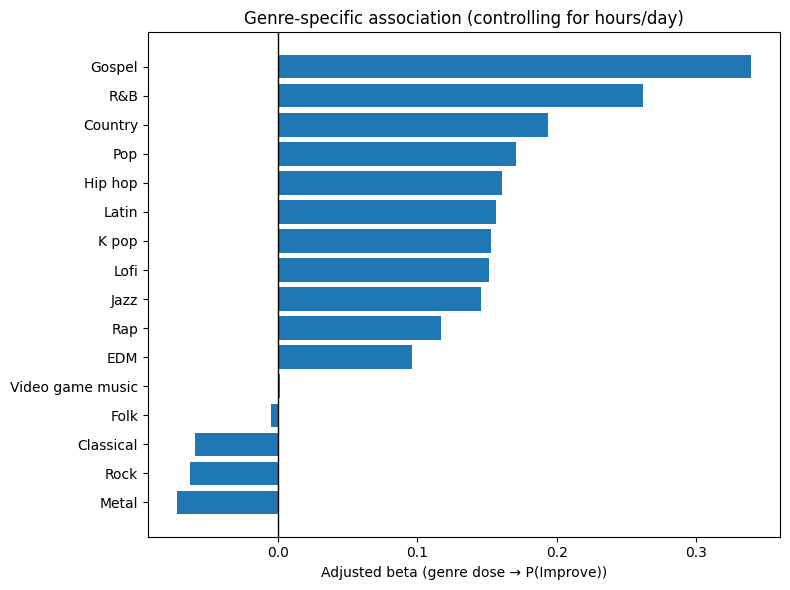

In [18]:
# Visualize adjusted genre-specific dose effects from the regression models
# Each bar represents the estimated effect of listening frequency ("dose")
# on the probability of reporting emotional improvement, controlling for hours/day

# Extract genre-level dose coefficients from fitted regression models
adj_data = []
for genre, res in model_meta.items():
    adj_data.append({
        "genre": genre,
        "beta_genre_dose": res["coef_dose"]
    })

# Convert to DataFrame for plotting
adj_df = pd.DataFrame(adj_data)

# Sort genres by estimated dose effect for clearer visualization
plot_df = adj_df.sort_values("beta_genre_dose")

# Create horizontal bar plot of adjusted dose coefficients
plt.figure(figsize=(8, 6))
plt.barh(plot_df["genre"], plot_df["beta_genre_dose"])

# Reference line indicating no association
plt.axvline(0, color="black", linewidth=1)

# Label axes and title
plt.xlabel("Adjusted beta (genre dose → P(Improve))")
plt.title("Genre-specific association (controlling for hours/day)")

# Improve spacing and render plot
plt.tight_layout()
plt.show()

Bars represent the adjusted association between genre-specific listening frequency and emotional benefit, holding total listening time constant. Positive values indicate that higher frequency of listening to a given genre is associated with higher likelihood of reporting improvement. Effect sizes are small, and statistical significance varies by genre.



## 9) Dose–effect relationship (single-genre example)


Dose–response tables (interpretable summaries)

For each genre and dose level, we compute:
- `mean_effect`: average effect_score
- `improve_rate/no_effect_rate/worsen_rate`: composition of Music effects
- `mean_hours`: average Hours per day for that dose level (context)


In [17]:
# Build a long-form table describing dose–response patterns by genre
# Each row represents a specific genre at a specific listening frequency ("dose")

dose_response_rows = []

# Iterate over each genre and its corresponding numeric dose column
for gcol, dcol in zip(genre_cols, dose_cols):

    # Extract a clean genre name from the column label
    gname = gcol.replace("Frequency [", "").replace("]", "")

    # Subset to relevant columns and drop rows missing dose information
    # (effect_score and Hours/day are allowed to be missing initially)
    tmp = core[[dcol, "effect_score", "Hours per day"]].dropna(subset=[dcol])

    # Loop over the four listening frequency levels:
    # 0 = Never, 1 = Rarely, 2 = Sometimes, 3 = Very frequently
    for dose in [0, 1, 2, 3]:

        # Select respondents at this specific listening frequency
        sub = tmp[tmp[dcol] == dose]

        # Skip dose levels with no respondents
        if len(sub) == 0:
            continue

        # Compute summary statistics for this genre–dose combination
        dose_response_rows.append({
            "genre": gname,
            "dose": dose,
            "n": len(sub),
            "mean_effect": sub["effect_score"].mean(),
            "improve_rate": (sub["effect_score"] == 1).mean(),
            "no_effect_rate": (sub["effect_score"] == 0).mean(),
            "worsen_rate": (sub["effect_score"] == -1).mean(),
            "mean_hours": sub["Hours per day"].mean()
        })

# Convert results into a DataFrame for analysis and visualization
dose_response = pd.DataFrame(dose_response_rows)

# Preview the structured dose–response table
display(dose_response.sort_values(["genre", "dose"]).head(60))


,genre,dose,n,mean_effect,improve_rate,no_effect_rate,worsen_rate,mean_hours
0,Classical,0,168,0.738095,0.761905,0.214286,0.023810,3.889881
1,Classical,1,255,0.729412,0.752941,0.223529,0.023529,3.390980
2,Classical,2,197,0.695431,0.720812,0.253807,0.025381,3.669289
3,Classical,3,108,0.722222,0.740741,0.240741,0.018519,3.458333
4,Country,0,339,0.690265,0.719764,0.250737,0.029499,3.509735
5,Country,1,231,0.714286,0.735931,0.242424,0.021645,3.518398
6,Country,2,109,0.798165,0.807339,0.183486,0.009174,3.935780
7,Country,3,49,0.795918,0.816327,0.163265,0.020408,3.734694
8,EDM,0,302,0.662252,0.698675,0.264901,0.036424,3.139238
9,EDM,1,193,0.808290,0.818653,0.170984,0.010363,3.777202


Selected dose–response curves (visual explanation)

We plot dose → mean_effect for a small set of representative genres:
- strongest positive association
- mid association
- near zero association
- most negative association

This visualization illustrates how the **improve rate score** changes as listening frequency increases for a single genre.

,dose,n,mean_effect,improve_rate,no_effect_rate,worsen_rate,mean_hours
0,0,179,0.648045,0.664804,0.318436,0.016760,3.179888
1,1,211,0.744076,0.763033,0.218009,0.018957,3.262322
2,2,216,0.763889,0.791667,0.180556,0.027778,3.810185
3,3,122,0.713115,0.745902,0.221311,0.032787,4.377049


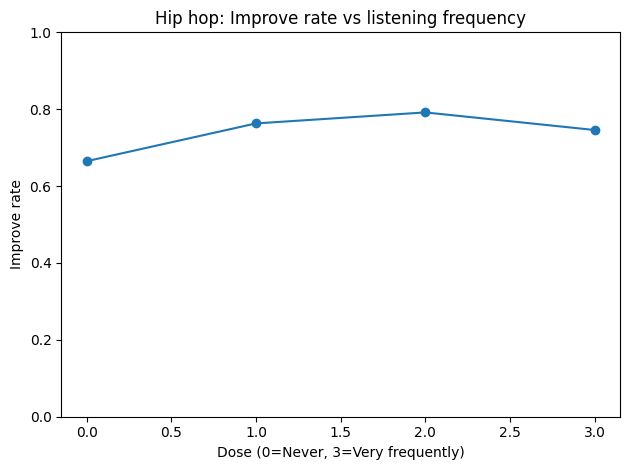

In [16]:
GENRE = "Hip hop"

gcol = f"Frequency [{GENRE}]"
dcol = gcol + " (dose)"

tmp = core[[dcol, "effect_score", "Music effects", "Hours per day"]].dropna(subset=[dcol])
table = tmp.groupby(dcol).agg(
    n=("effect_score", "size"),
    mean_effect=("effect_score", "mean"),
    improve_rate=("effect_score", lambda s: (s == 1).mean()),
    no_effect_rate=("effect_score", lambda s: (s == 0).mean()),
    worsen_rate=("effect_score", lambda s: (s == -1).mean()),
    mean_hours=("Hours per day", "mean"),
).reset_index().rename(columns={dcol: "dose"})

display(table)

plt.figure()
plt.plot(table["dose"], table["improve_rate"], marker="o")
plt.title(f"{GENRE}: Improve rate vs listening frequency")
plt.xlabel("Dose (0=Never, 3=Very frequently)")
plt.ylabel("Improve rate")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


For hip hop listeners, the probability of reporting emotional improvement increases from never to moderate listening frequency, then plateaus and slightly declines at very frequent listening. This non-linear pattern suggests diminishing returns rather than a monotonic dose–response relationship, consistent with the broader finding that **emotional benefit is not simply proportional to listening more.**



## 10) Dose–effect relationship (multi-genre example)

This visualization illustrates how the **mean effect score** changes as listening frequency increases for all genres.


Selected genres: ['R&B', 'K pop', 'Video game music', 'Metal']


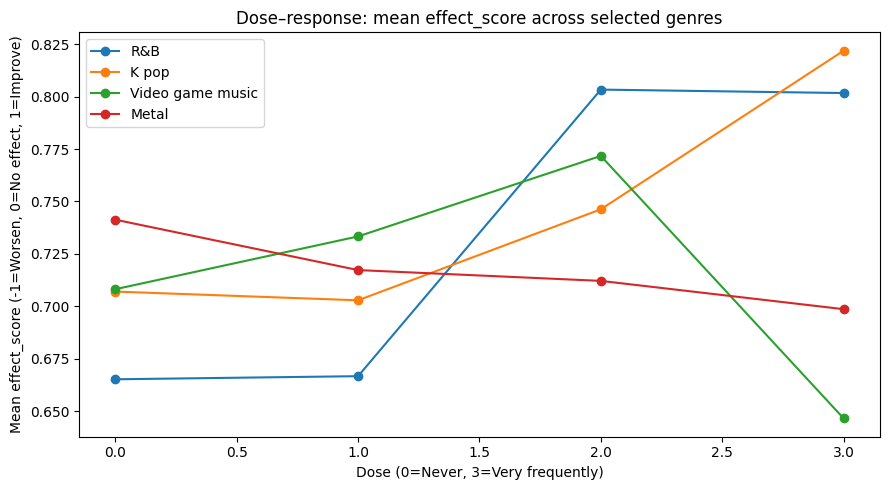

In [15]:
top = rank_df.iloc[0]["genre"]
mid = rank_df.iloc[len(rank_df)//2]["genre"]
near0 = rank_df.iloc[(rank_df["spearman_rho"].abs()).argmin()]["genre"]
neg = rank_df.iloc[-1]["genre"]

selected = [top, mid, near0, neg]
print("Selected genres:", selected)

plt.figure(figsize=(9, 5))
for g in selected:
    sub = dose_response[dose_response["genre"] == g].sort_values("dose")
    plt.plot(sub["dose"], sub["mean_effect"], marker="o", label=g)

plt.title("Dose–response: mean effect_score across selected genres")
plt.xlabel("Dose (0=Never, 3=Very frequently)")
plt.ylabel("Mean effect_score (-1=Worsen, 0=No effect, 1=Improve)")
plt.legend()
plt.tight_layout()
plt.show()

Mean emotional benefit does not increase monotonically with listening frequency for all genres. This non-linear pattern suggests that higher exposure does not necessarily imply greater benefit and may reflect differences in listening context, mood regulation strategies, or self-selection.


While some genres show positive adjusted associations, effect sizes are modest and not uniformly statistically significant, underscoring that **music’s emotional impact is likely multifactorial rather than genre-deterministic.**


## Key takeaways

* Mental health associations with music listening appear to be **partially genre-specific**, rather than driven solely by listening more overall.

* After adjusting for total listening time (hours per day), some genres (e.g., Gospel, R&B, Country) show small but consistent positive associations between listening frequency and self-reported emotional benefit, while others show neutral or negative trends.

* Importantly, dose–response patterns are **not universally linear** across genres, suggesting that how music is experienced may depend on genre context, listener intent, and individual differences rather than exposure alone.


## Future Directions

This analysis focuses on overall listening patterns and genre-specific associations at the population level. Future work could explore:

- Whether genre–emotion associations differ by demographic factors such as age or self-reported mental health conditions, where sample sizes permit.
- Longitudinal designs that follow the same individuals over time could assess whether within-person changes in listening behavior are associated with changes in emotional state, rather than relying on cross-sectional comparisons.
- More granular musical features (e.g., tempo, lyrical content, familiarity) that may better explain emotional response than genre labels alone.

These directions would help clarify whether observed associations reflect stable preferences, situational coping strategies, or broader contextual factors.


## Data Source

This analysis uses the **Music & Mental Health Survey (MXMH)** dataset, a publicly available, self-reported survey capturing music listening habits, genre preferences, listening duration, and perceived emotional effects.

Dataset available at:  
https://www.kaggle.com/datasets/catherinerasgaitis/mxmh-survey-results
